In [87]:
class Rect:
    def __init__(self, top, left, height, width):
        self.top = top
        self.left = left
        self.height = height
        self.width = width

        self.bottom = top + height
        self.right = left + width

    def __str__(self):
        return "(" + str(self.top) + ", " + str(self.left) + ", " + str(self.bottom) + ", " + str(self.right) + ")"

    def __repr__(self):
        return self.__str__()


In [88]:
def getDBAlbumXMLConfig(mcfxFile):
    import sqlite3

    con = sqlite3.connect(mcfxFile)
    cur = con.cursor()
    res = cur.execute("SELECT Data FROM Files WHERE Filename='data.mcf'")

    xmlData = res.fetchone()

    print('Successfully read XML data from', mcfxFile)
    cur.close()
    con.close()
    
    
    # with open('data.mcf.xml', "wb") as f:
    #     f.write(xmlData[0])
    
    xmlString = xmlData[0].decode('UTF8')
    xmlString = xmlString[:xmlString.find('</fotobook>')+11]

    return xmlString

In [89]:
def getPagesWithImages(xmlString):
        
    import xml.etree.ElementTree as et
    tree = et.fromstring(xmlString)
    parentMap = {c: p for p in tree.iter() for c in p}

    images = {}

    for areaElement in tree.iter('area'):
        if areaElement.get('areatype') == 'imagearea':
            parentElement = parentMap[areaElement]
            pageNumber = int(parentElement.get('pagenr'))

            # <position height="3160" left="-100" rotation="0" top="-100" width="6309.18" zposition="100"/>
            positionElement = areaElement.find('position')
            h = float(positionElement.get('height'))
            w = float(positionElement.get('width'))
            l = float(positionElement.get('left'))
            t = float(positionElement.get('top'))
            rect = Rect(t, l, h, w)

            # <image filename="safecontainer:/i6bs7459_1_img_8369_stitch.jpg" useABK="0">
            imageElement = areaElement.find('image')
            filename = imageElement.get('filename')[15:]

            if not pageNumber in images:
                images[pageNumber] = []

            # images[pageNumber].append((filename, rect))
            images[pageNumber].append(rect)

    return images

In [104]:
def interfereHorizontally(i1, i2):
    if (i1.left >= i2.left and i1.left <= i2.right) or (i1.right >= i2.left and i1.right <= i2.right) or (i1.left < i2.left and i1.right > i2.right):
        return True
    return False

def interfereVertically(i1, i2):
    if (i1.top >= i2.top and i1.top <= i2.bottom) or (i1.bottom >= i2.top and i1.bottom <= i2.bottom) or (i1.top < i2.top and i1.bottom > i2.bottom):
        return True
    return False

def getDesiredRightSides(i1, i2, margin):
    resultingConstraints = []

    if i1.right <= i2.left:
        if interfereVertically(i1, i2):
            mid = i1.right + (i2.left - i1.right) / 2
            resultingConstraints.append((i1, 'R', mid - margin/2))
            resultingConstraints.append((i2, 'L', mid + margin/2))
            # return (mid - margin/2, mid + margin/ 2)
    elif i1.left >= i2.right:
        if interfereVertically(i1, i2):
            mid = i2.right + (i1.left - i2.right) / 2
            resultingConstraints.append((i1, 'L', mid + margin/2))
            resultingConstraints.append((i2, 'R', mid - margin/2))
            # return (mid + margin/2, mid - margin/ 2)

    if i1.bottom <= i2.top:
        if interfereHorizontally(i1, i2):
            mid = i1.bottom + (i2.top - i1.bottom) / 2
            resultingConstraints.append((i1, 'B', mid - margin/2))
            resultingConstraints.append((i2, 'T', mid + margin/2))
    elif i1.top >= i2.bottom:
        if interfereHorizontally(i1, i2):
            mid = i2.bottom + (i1.top - i2.bottom) / 2
            resultingConstraints.append((i1, 'T', mid + margin/2))
            resultingConstraints.append((i2, 'B', mid - margin/2))

    return resultingConstraints

In [119]:
xmlString = getDBAlbumXMLConfig('test.mcfx')

pages = getPagesWithImages(xmlString)

pageHeight = 2900 #2960
pageWidth = 5800 #6010
newMargin = 100

for pageNumber in [2]: #pages:
    images = pages[pageNumber]
    print(images)

    # newCoordsRight = {i:i.right for i in images}
    allConstraints = []

    for i1 in images:
        for i2 in images:
            resultingConstraints = getDesiredRightSides(i1, i2, newMargin)
            allConstraints = allConstraints + resultingConstraints
            # allConstraints.append(resultingConstraints)
            # for c in resultingConstraints:

            # if r1 > newCoordsRight[i1]: newCoordsRight[i1] = r1
            # if r2 > newCoordsRight[i2]: newCoordsRight[i2] = r2

    newCoordinates = {i:{'T':i.top, 'B':i.bottom, 'L':i.left, 'R':i.right} for i in images}

    for c in allConstraints:
        oldVal = newCoordinates[c[0]][c[1]]
        if c[1]=='T' or c[1]=='L':
            if c[2] > oldVal:
                newCoordinates[c[0]][c[1]] = c[2]
        else:
            if c[2] < oldVal:
                newCoordinates[c[0]][c[1]] = c[2]

    newCoordinates

Successfully read XML data from test.mcfx
[(1010.0, 1425.0, 1650.0, 2150.0), (50.0, 1425.0, 964.063, 2150.0), (50.0, 50.0, 1650.0, 1375.0), (1700.01, 50.0, 2850.0, 1800.0), (50.0, 3650.0, 1400.0, 5750.0), (1450.0, 3650.0, 2850.0, 5750.0), (1700.0, 1850.0, 2850.0, 3600.0), (50.0, 2200.0, 1650.0, 3600.0)]


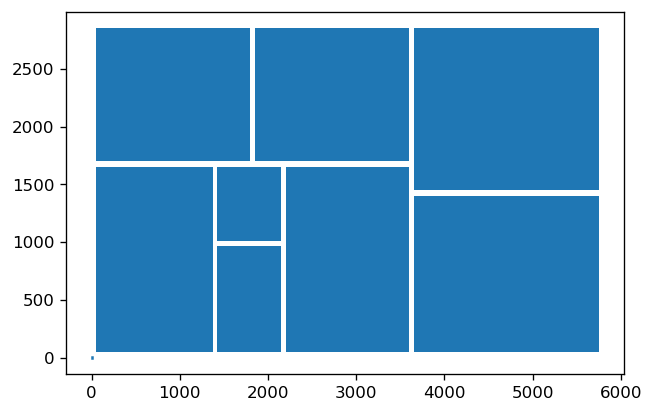

In [76]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
plt.rcParams['figure.dpi'] = 120

fig, ax = plt.subplots()
ax.plot([0, 0],[10, 0])

for i in pages[2]:
    ax.add_patch(Rectangle((i.left, i.top), i.width, i.height))

plt.show()